In [1]:
import functools
import hashlib
import io
import pathlib
import shutil
import urllib.request
import zipfile

URL = 'https://zenodo.org/record/841982/files/xflr6/portmanteaus-v1.0.zip'

CSV = pathlib.Path('esm3-analyses.csv')


if not CSV.exists():
    with io.BytesIO() as b:
        with urllib.request.urlopen(URL) as u:
            shutil.copyfileobj(u, b)
        with zipfile.ZipFile(b) as z:
            i, = (i for i in z.infolist() if i.filename.endswith(CSV.name))
            i.filename = CSV.name
            z.extract(i)


def sha256sum(filename, bufsize=32768) -> str:
    s = hashlib.sha256()
    with io.open(filename, 'rb') as fd:
        for data in iter(functools.partial(fd.read, bufsize), b''):
            s.update(data)
    return s.hexdigest()


sha256sum(CSV)

'6e6389a913cc01020d03ac16217bc1c63c9d0e16b78179b4c931741c0d5a69cf'

In [2]:
%matplotlib inline

import types
import warnings

import matplotlib.pyplot as plt
import numpy as np
from numpy import count_nonzero as ntrue
import pandas as pd
import scipy.stats


plt.style.use('classic')
plt.rcParams.update({'figure.figsize': (6, 4), 'figure.facecolor': 'w',
                     'figure.subplot.bottom': .125, 'font.size': 10, 'savefig.dpi': 72})


def crosstab(df, index, columns, tests=False, margins=True, **kwargs):
    idx = [df[i] for i in index] if isinstance(index, list) else df[index]
    cols = [df[c] for c in columns] if isinstance(columns, list) else df[columns]
    result = pd.crosstab(idx, cols, margins=margins, **kwargs)
    if tests:
        result = types.SimpleNamespace(df=result)
        values = result.df.iloc[:-1, :-1] if margins else result.df
        testres = chi2_contingency(values), fisher_exact(values)
        label = tests if isinstance(tests, str) else f'{index} & {columns}'
        testres = [tr.to_frame(label).T for tr in testres]
        result.expected = pd.DataFrame(
            testres[0].at[label, 'expected'],
            index=values.index, columns=values.columns)
        result.chi2, result.fisher_exact = testres
    return result


def chi2_contingency(x, func=scipy.stats.chi2_contingency):
    try:
        chi2, p, dof, expected = func(x)
    except ValueError:
        return
    result = chi2, p, dof, expected, (expected >= 5).all()
    return pd.Series(result, index=('chi2', 'p', 'dof', 'expected', 'usable'))


def fisher_exact(x, func=scipy.stats.fisher_exact):
    return pd.Series(func(x), index=('odds', 'p'))


def pearsonr(df, left, right, func=scipy.stats.pearsonr):
    df = df[[left, right]].dropna()
    name = f'{left} & {right}'
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', scipy.stats.PearsonRConstantInputWarning)
        with np.errstate(invalid='ignore'):
            result = func(df[left], df[right])
    return pd.Series(result, index=('r', 'p'), name=name)


RENAME = {'Quechua (Ayacucho)': 'Ayacucho',
          'Tlachichilco Tepehuan': 'Tepehua',
          'Lakhota': 'Lakota'}


df = pd.read_csv(CSV, encoding='utf-8')

df['Language'] = df['Language'].replace(RENAME)

df.info()
assert df.set_index(['Language', 'Cell', 'Position']).index.is_unique
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Language  2818 non-null   object
 1   Cell      2818 non-null   object
 2   Position  2818 non-null   int64 
 3   Form      2818 non-null   object
 4   Meaning   2818 non-null   object
dtypes: int64(1), object(4)
memory usage: 110.2+ KB


,Language,Cell,Position,Form,Meaning
0,Ainu,1s,-1,ku,SA[+1 +sg]
1,Ainu,1p,1,as,S[+1 +pl]
2,Ainu,2s,-1,e,SAP[-3 +sg]
3,Ainu,2p,-1,eci,SAP[+2]
4,Ainu,x,1,an,S[-1 -2 -3]
5,Ainu,1s->2s,-1,eci,SAP[+2]
6,Ainu,1s->2p,-1,eci,SAP[+2]
7,Ainu,1s->3s,-1,ku,SA[+1 +sg]
8,Ainu,1s->3p,-1,ku,SA[+1 +sg]
9,Ainu,1s->x,-2,ku,SA[+1 +sg]


In [3]:
import itertools

SEP = '->'


def is_local(cellkey, sep=SEP, persons=('1', '2')) -> bool:
    subj, _, obj = cellkey.partition(sep)
    return any(p in subj for p in persons) and any(p in obj for p in persons)


def is_inverse(cellkey, sep=SEP, hierarchy=('1', '2', '3', '4', 'x')) -> bool:
    subj, _, obj = cellkey.partition(sep)
    for high, low in itertools.combinations(hierarchy, 2):
        if low in subj and high in obj:
            return True
    return False


def is_inverse_restricted(cellkey, sep=SEP, high=('1', '2'), low=('3', '4', 'x')) -> bool:
    subj, _, obj = cellkey.partition(sep)
    return any(l in subj for l in low) and any(h in obj for h in high)


def is_inverse_relaxed(cellkey, sep=SEP, high=('1', '2')) -> bool:
    subj, _, obj = cellkey.partition(sep)
    return any(h in obj for h in high)


def get_slot(cellpos) -> bool:
    return 'prefix' if cellpos < 0 else 'suffix' if cellpos > 0 else 'stem'


df.insert(2, 'Trans', df['Cell'].str.contains(SEP))
df.insert(3, 'Local', df['Cell'].map(is_local))
df.insert(4, 'Direct', ~df['Cell'].map(is_inverse))
df.insert(6, 'Slot', df['Position'].map(get_slot))
df.insert(9, 'Portmx', df['Meaning'].str.contains(SEP))

df.head(10)

,Language,Cell,Trans,Local,Direct,Position,Slot,Form,Meaning,Portmx
0,Ainu,1s,False,False,True,-1,prefix,ku,SA[+1 +sg],False
1,Ainu,1p,False,False,True,1,suffix,as,S[+1 +pl],False
2,Ainu,2s,False,False,True,-1,prefix,e,SAP[-3 +sg],False
3,Ainu,2p,False,False,True,-1,prefix,eci,SAP[+2],False
4,Ainu,x,False,False,True,1,suffix,an,S[-1 -2 -3],False
5,Ainu,1s->2s,True,True,True,-1,prefix,eci,SAP[+2],False
6,Ainu,1s->2p,True,True,True,-1,prefix,eci,SAP[+2],False
7,Ainu,1s->3s,True,False,True,-1,prefix,ku,SA[+1 +sg],False
8,Ainu,1s->3p,True,False,True,-1,prefix,ku,SA[+1 +sg],False
9,Ainu,1s->x,True,False,True,-2,prefix,ku,SA[+1 +sg],False


In [4]:
df['Language'].nunique()

26

In [5]:
df.pivot_table('Position', 'Trans', 'Local', aggfunc=len, fill_value=0, margins=True)

Local,False,True,All
Trans,,,
False,270,0,270
True,1963,585,2548
All,2233,585,2818


In [6]:
(df.groupby(['Language', 'Cell'])[['Trans', 'Local']].first()
 .pivot_table(index='Trans', columns='Local', aggfunc=len, fill_value=0, margins=True))

Local,False,True,All
Trans,,,
False,186,0,186
True,890,241,1131
All,1076,241,1317


In [7]:
df.groupby('Language')['Cell'].nunique().to_frame()

,Cell
Language,
Ainu,42
Aleut,72
Ayacucho,39
Bella Coola,34
Chuckchi,33
Darai,34
Fox,49
Hixkaryana,35
Jaqaru,14


In [8]:
(df.groupby(['Language', 'Cell'])['Position'].size()
 .groupby(level='Language').mean()
 .to_frame('marker/cell')
 .sort_values(by='marker/cell')
 .describe())

,marker/cell
count,26.000000
mean,1.975917
std,0.659278
min,1.000000
25%,1.443182
50%,1.911855
75%,2.460084
max,3.361111


In [9]:
(df.groupby(['Language', 'Cell'])['Position'].size()
 .groupby(level='Language').mean()
 .std(ddof=0))

0.6464749527797673

## Learned lexemes

In [10]:
assert (df.groupby(['Language', 'Form', 'Meaning'])[['Slot', 'Portmx']]
        .filter(lambda g: (g.nunique() > 1).any())
        .empty)

(df.groupby(['Language', 'Form', 'Meaning'])[['Slot', 'Portmx']].first()
 .pivot_table(index='Slot', columns='Portmx', aggfunc=len, fill_value=0, margins=True))

Portmx,False,True,All
Slot,,,
prefix,132,50,182
suffix,119,55,174
All,251,105,356


In [11]:
(df.groupby(['Language', 'Form', 'Meaning'], as_index=False)['Portmx'].first()
 .pivot_table('Form', 'Language', 'Portmx', aggfunc=len, fill_value=0, margins=True))

Portmx,False,True,All
Language,,,
Ainu,9,1,10
Aleut,8,9,17
Ayacucho,6,2,8
Bella Coola,9,2,11
Chuckchi,10,5,15
Darai,9,2,11
Fox,13,4,17
Hixkaryana,7,2,9
Jaqaru,4,5,9


In [12]:
llf = (df.groupby(['Language', 'Form', 'Meaning', 'Portmx'], as_index=False)['Local']
       .agg(lambda x: True if x.all() else False if not x.any() else None)
       .query('Local == Local')
       .pivot_table('Form', ['Language', 'Local'], 'Portmx', aggfunc=len, fill_value=0, dropna=False))

(llf.join(llf.groupby(level='Language').apply(fisher_exact))
 .rename_axis('Portmx', axis=1)
 .query('p <= .05'))

,Portmx,False,True,odds,p
Language,Local,,,,


In [13]:
dlf = (df.groupby(['Language', 'Form', 'Meaning', 'Portmx'], as_index=False)['Direct']
       .agg(lambda x: True if x.all() else False if not x.any() else None)
       .query('Direct == Direct')  # filter out Nan
       .pivot_table('Form', ['Language', 'Direct'], 'Portmx', aggfunc=len, fill_value=0, dropna=False))

(dlf.join(llf.groupby(level='Language').apply(fisher_exact))
 .rename_axis('Portmx', axis=1)
 .query('p <= .05'))

,Portmx,False,True,odds,p
Language,Direct,,,,


## Transitive occurrences

In [14]:
ct = crosstab(df[df['Trans']], 'Local', 'Portmx', tests=True)
ct.df

Portmx,False,True,All
Local,,,
False,1725,238,1963
True,528,57,585
All,2253,295,2548


In [15]:
ct.expected

Portmx,False,True
Local,,
False,1735.729592,227.270408
True,517.270408,67.729592


In [16]:
ct.chi2.drop('expected', axis=1)

,chi2,p,dof,usable
Local & Portmx,2.268065,0.132065,1,True


In [17]:
ct.fisher_exact

,odds,p
Local & Portmx,0.782444,0.122239


In [18]:
of = (df[df['Trans']]
      .groupby(['Language', 'Local'])['Portmx']
      .agg([('Markers', 'size'), ('Portmx', ntrue)]))

of['Ratio'] = 100 * of['Portmx'] / of['Markers']
of['Ratio (norm)'] = of['Ratio'] / of['Ratio'].groupby(level='Language').sum()
of.loc[of['Ratio (norm)'].isnull(), 'Ratio'] = None

ofp = of.reset_index('Local')

of.unstack('Local')

Markers      Portmx           Ratio            Ratio (norm)  \
Local         False True  False True      False       True        False   
Language                                                                  
Ainu             41   12      2    0   4.878049   0.000000     1.000000   
Aleut            66   33     21    0  31.818182   0.000000     1.000000   
Ayacucho         62   22      4    4   6.451613  18.181818     0.261905   
Bella Coola      37   21      3    0   8.108108   0.000000     1.000000   
Chuckchi         29   12      5    4  17.241379  33.333333     0.340909   
Darai            53   20      4    0   7.547170   0.000000     1.000000   
Fox             115   24     14    4  12.173913  16.666667     0.422111   
Hixkaryana       22    6      4    0  18.181818   0.000000     1.000000   
Jaqaru            9    7      3    4  33.333333  57.142857     0.368421   
Jumjum           55   19     12    5  21.818182  26.315789     0.453280   
Karuk            25   11      4    1  16.000000   9.090909     0.637681   
Ket             196   22      0    0        NaN        NaN          NaN   
Kunama          139   47     37    1  26.618705   2.127660     0.925985   
Lakota           42   20      0    2   0.000000  10.000000     0.000000   
Maricopa         16   16      0    0        NaN        NaN          NaN   
Maung           255   18     69    5  27.058824  27.777778     0.493445   
Mordvin          31    9     10    1  32.258065  11.111111     0.743802   
Nocte            22    8      4    2  18.181818  25.000000     0.421053   
Reyesano         32   12      0    0        NaN        NaN          NaN   
Sahu            195   24      0    0        NaN        NaN          NaN   
Siuslawan       178   61     12    1   6.741573   1.639344     0.804396   
Tepehua          56   32      2    9   3.571429  28.125000     0.112676   
Thangmi          39   18      1    3   2.564103  16.666667     0.133333   
Turkana          28   10      4    0  14.285714   0.000000     1.000000   
Wardaman         67   25      8    4  11.940299  16.000000     0.427350   
Yimas           153   76     15    7   9.803922   9.210526     0.515604   

                       
Local            True  
Language               
Ainu         0.000000  
Aleut        0.000000  
Ayacucho     0.738095  
Bella Coola  0.000000  
Chuckchi     0.659091  
Darai        0.000000  
Fox          0.577889  
Hixkaryana   0.000000  
Jaqaru       0.631579  
Jumjum       0.546720  
Karuk        0.362319  
Ket               NaN  
Kunama       0.074015  
Lakota       1.000000  
Maricopa          NaN  
Maung        0.506555  
Mordvin      0.256198  
Nocte        0.578947  
Reyesano          NaN  
Sahu              NaN  
Siuslawan    0.195604  
Tepehua      0.887324  
Thangmi      0.866667  
Turkana      0.000000  
Wardaman     0.572650  
Yimas        0.484396

In [19]:
pd.DataFrame([pearsonr(ofp, 'Local', c) for c in ['Ratio', 'Ratio (norm)']])

,r,p
Local & Ratio,-0.040995,0.791617
Local & Ratio (norm),-0.277682,0.068004


In [20]:
ctl = (df[df['Trans']]
       .pivot_table('Position', ['Language', 'Local'], 'Portmx', aggfunc=len, fill_value=0))

(ctl.join(ctl.groupby(level='Language').apply(chi2_contingency))
 .rename_axis('Portmx', axis=1)
 .query('usable == 1 & p <= .05'))

Portmx          False  True       chi2         p  dof  \
Language Local                                          
Aleut    False     45    21  11.491071  0.000699  1.0   
         True      33     0  11.491071  0.000699  1.0   
Kunama   False    102    37  11.496919  0.000697  1.0   
         True      46     1  11.496919  0.000697  1.0   

Portmx                                                   expected usable  
Language Local                                                            
Aleut    False                        [[52.0, 14.0], [26.0, 7.0]]   True  
         True                         [[52.0, 14.0], [26.0, 7.0]]   True  
Kunama   False  [[110.60215053763442, 28.397849462365592], [37...   True  
         True   [[110.60215053763442, 28.397849462365592], [37...   True

In [21]:
(ctl.join(ctl.groupby(level='Language').apply(fisher_exact))
 .rename_axis('Portmx', axis=1)
 .query('p <= .05'))

Portmx          False  True       odds         p
Language Local                                  
Aleut    False     45    21   0.000000  0.000062
         True      33     0   0.000000  0.000062
Kunama   False    102    37   0.059929  0.000102
         True      46     1   0.059929  0.000102
Tepehua  False     54     2  10.565217  0.001467
         True      23     9  10.565217  0.001467

## Transitive cells

In [22]:
cells = (df[df['Trans']]
         .groupby(['Language', 'Cell', 'Local', 'Direct'], sort=False)['Portmx']
         .agg([('Markers', 'size'), ('Portmx', ntrue), ('Hasp', 'any')])
         .reset_index(['Local', 'Direct']))

cells['Ratio'] = 100 * cells['Portmx'] / cells['Markers']

cells

Local  Direct  Markers  Portmx   Hasp      Ratio
Language Cell                                                    
Ainu     1s->2s   True    True        1       0  False   0.000000
         1s->2p   True    True        1       0  False   0.000000
         1s->3s  False    True        1       0  False   0.000000
         1s->3p  False    True        1       0  False   0.000000
         1s->x   False    True        2       0  False   0.000000
...                ...     ...      ...     ...    ...        ...
Yimas    3p->2d  False   False        4       0  False   0.000000
         3p->2p  False   False        3       0  False   0.000000
         3p->3s  False    True        4       1   True  25.000000
         3p->3d  False    True        4       1   True  25.000000
         3p->3p  False    True        3       1   True  33.333333

[1131 rows x 6 columns]

In [23]:
cells.groupby(level='Language').apply(lambda x: pearsonr(x, 'Ratio', 'Markers'))

Ratio & Markers,r,p
Language,,
Ainu,-0.173851,0.303450
Aleut,0.035474,0.782539
Ayacucho,-0.216970,0.232945
Bella Coola,0.240767,0.217134
Chuckchi,-0.024049,0.905222
Darai,-0.036824,0.852418
Fox,-0.132580,0.414771
Hixkaryana,NaN,NaN
Jaqaru,-0.167380,0.643943


In [24]:
ct = crosstab(cells, 'Local', 'Hasp', tests=True)

ct.df

Hasp,False,True,All
Local,,,
False,686,204,890
True,196,45,241
All,882,249,1131


In [25]:
ct.expected

Hasp,False,True
Local,,
False,694.058355,195.941645
True,187.941645,53.058355


In [26]:
ct.chi2.drop('expected', axis=1)

,chi2,p,dof,usable
Local & Hasp,1.754557,0.185305,1,True


In [27]:
ct.fisher_exact

,odds,p
Local & Hasp,0.772059,0.162222


In [28]:
pd.DataFrame([pearsonr(cells, 'Local', c) for c in ['Hasp', 'Ratio']])

,r,p
Local & Hasp,-0.041992,0.158161
Local & Ratio,-0.052016,0.080369


In [29]:
ctl = cells.pivot_table('Markers', ['Language', 'Local'], 'Hasp', aggfunc=len, fill_value=0)

(ctl.join(ctl.groupby(level='Language').apply(chi2_contingency))
 .rename_axis('Hasp', axis=1)
 .query('usable == 1 & p <= .05'))

Hasp            False  True      chi2         p  dof  \
Language Local                                         
Kunama   False     30    27  8.513763  0.003525  1.0   
         True      17     1  8.513763  0.003525  1.0   

Hasp                                   expected usable  
Language Local                                          
Kunama   False  [[35.72, 21.28], [11.28, 6.72]]   True  
         True   [[35.72, 21.28], [11.28, 6.72]]   True

In [30]:
(ctl.join(ctl.groupby(level='Language').apply(fisher_exact))
 .rename_axis('Hasp', axis=1)
 .query('p <= .05'))

Hasp            False  True       odds         p
Language Local                                  
Aleut    False     29    16   0.000000  0.002852
         True      18     0   0.000000  0.002852
Kunama   False     30    27   0.065359  0.001533
         True      17     1   0.065359  0.001533
Tepehua  False     21     2  31.500000  0.000921
         True       2     6  31.500000  0.000921

## Cells with portmanteau vs. Occurrences vs. Mean cell ratio

In [31]:
cf = (cells.reset_index()
      .groupby(['Language', 'Local'])
      .agg({'Cell': 'size', 'Hasp': ntrue, 'Markers': 'sum',
            'Portmx': 'sum', 'Ratio': 'mean'})
      .rename(columns={'Cell': 'Cells', 'Ratio': 'Cell ratio'}))

cf.insert(2, 'Perc', 100 * cf['Hasp'] / cf['Cells'])
cf.insert(5, 'Ratio', 100 * cf['Portmx'] / cf['Markers'])
nf = cf[['Perc', 'Ratio', 'Cell ratio']]
nf /= nf.groupby(level='Language').sum()
cf = cf.join(nf, rsuffix=' (norm)')
cf.loc[cf['Perc (norm)'].isnull(), ['Perc', 'Ratio', 'Cell ratio']] = None

cfp = cf.reset_index('Local')

cf = cf.unstack('Local')

cf.loc[:, :'Cell ratio']

Cells       Hasp            Perc             Markers      Portmx  \
Local       False True False True      False        True   False True  False   
Language                                                                       
Ainu           29    8     2    0   6.896552    0.000000      41   12      2   
Aleut          45   18    16    0  35.555556    0.000000      66   33     21   
Ayacucho       24    8     4    4  16.666667   50.000000      62   22      4   
Bella Coola    20    8     3    0  15.000000    0.000000      37   21      3   
Chuckchi       19    8     5    4  26.315789   50.000000      29   12      5   
Darai          20    8     4    0  20.000000    0.000000      53   20      4   
Fox            32    8    14    4  43.750000   50.000000     115   24     14   
Hixkaryana     22    6     4    0  18.181818    0.000000      22    6      4   
Jaqaru          7    3     3    3  42.857143  100.000000       9    7      3   
Jumjum         28    8    11    4  39.285714   50.000000      55   19     12   
Karuk          20    8     4    1  20.000000   12.500000      25   11      4   
Ket            84    8     0    0        NaN         NaN     196   22      0   
Kunama         57   18    27    1  47.368421    5.555556     139   47     37   
Lakota         23    8     0    2   0.000000   25.000000      42   20      0   
Maricopa       16    8     0    0        NaN         NaN      16   16      0   
Maung          96    8    58    3  60.416667   37.500000     255   18     69   
Mordvin        20    8     9    1  45.000000   12.500000      31    9     10   
Nocte          20    8     4    2  20.000000   25.000000      22    8      4   
Reyesano       20    8     0    0        NaN         NaN      32   12      0   
Sahu           96    8     0    0        NaN         NaN     195   24      0   
Siuslawan      57   18     9    1  15.789474    5.555556     178   61     12   
Tepehua        23    8     2    6   8.695652   75.000000      56   32      2   
Thangmi        20    8     1    2   5.000000   25.000000      39   18      1   
Turkana        20    8     4    0  20.000000    0.000000      28   10      4   
Wardaman       27    8     8    3  29.629630   37.500000      67   25      8   
Yimas          45   18    12    4  26.666667   22.222222     153   76     15   

                      Ratio            Cell ratio             
Local       True      False       True      False       True  
Language                                                      
Ainu           0   4.878049   0.000000   6.896552   0.000000  
Aleut          0  31.818182   0.000000  28.888889   0.000000  
Ayacucho       4   6.451613  18.181818   4.513889  31.250000  
Bella Coola    0   8.108108   0.000000   5.833333   0.000000  
Chuckchi       4  17.241379  33.333333  21.052632  25.000000  
Darai          0   7.547170   0.000000   7.916667   0.000000  
Fox            4  12.173913  16.666667  12.552083  17.708333  
Hixkaryana     0  18.181818   0.000000  18.181818   0.000000  
Jaqaru         4  33.333333  57.142857  42.857143  55.555556  
Jumjum         5  21.818182  26.315789  27.023810  34.375000  
Karuk          1  16.000000   9.090909  17.500000   6.250000  
Ket            0        NaN        NaN        NaN        NaN  
Kunama         1  26.618705   2.127660  28.654971   1.851852  
Lakota         2   0.000000  10.000000   0.000000  18.750000  
Maricopa       0        NaN        NaN        NaN        NaN  
Maung          5  27.058824  27.777778  29.774306  25.000000  
Mordvin        1  32.258065  11.111111  33.333333  12.500000  
Nocte          2  18.181818  25.000000  20.000000  25.000000  
Reyesano       0        NaN        NaN        NaN        NaN  
Sahu           0        NaN        NaN        NaN        NaN  
Siuslawan      1   6.741573   1.639344   4.970760   1.111111  
Tepehua        9   3.571429  28.125000   2.536232  24.375000  
Thangmi        3   2.564103  16.666667   1.250000   9.375000  
Turkana        0  14.285714   0.000000  15.000000   0

In [32]:
# Point-biserial correlation = Pearson r
pd.DataFrame([pearsonr(cfp, 'Local', c) for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Local & Perc,0.021124,0.891740
Local & Ratio,-0.040995,0.791617
Local & Cell ratio,-0.069615,0.653413


In [33]:
cfp[['Perc', 'Ratio', 'Cell ratio']].corr()

,Perc,Ratio,Cell ratio
Perc,1.000000,0.893704,0.873536
Ratio,0.893704,1.000000,0.956063
Cell ratio,0.873536,0.956063,1.000000


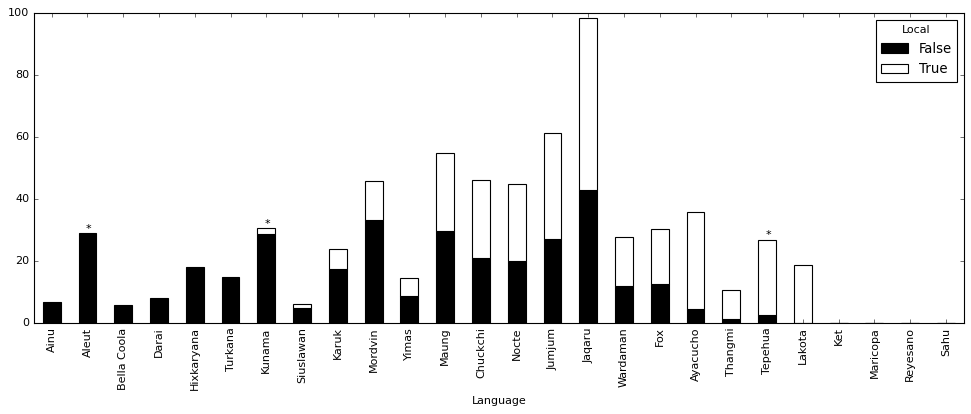

In [34]:
ax = (cf.sort_values(by=('Cell ratio (norm)', True), kind='mergesort')['Cell ratio']
      .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray))

for x, lang in [(1, 'Aleut'), (6, 'Kunama'), (20, 'Tepehua')]:
    ax.annotate('*', (x - .05, cf.loc[lang, 'Cell ratio'].sum() + .5))

#ax.get_figure().savefig('results_local.pdf', bbox_inches='tight')

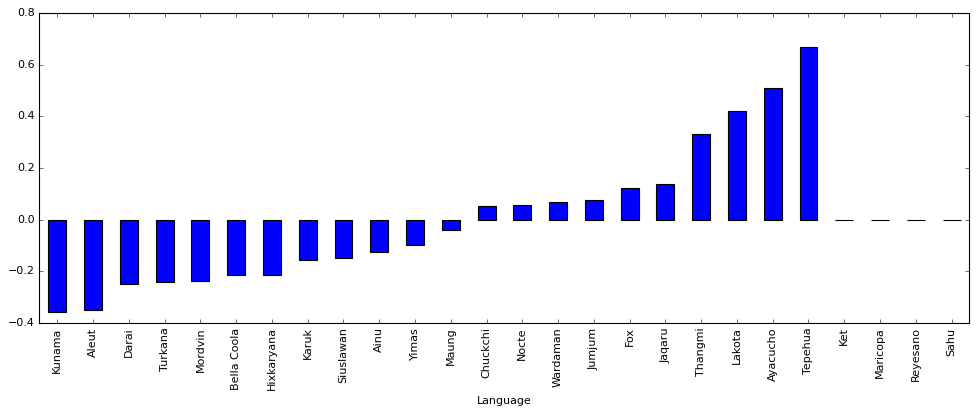

In [35]:
(cells.groupby(level='Language').apply(lambda x: pearsonr(x, 'Local', 'Ratio'))['r']
 .sort_values(kind='mergesort')
 .plot.bar(figsize=(15, 5)));

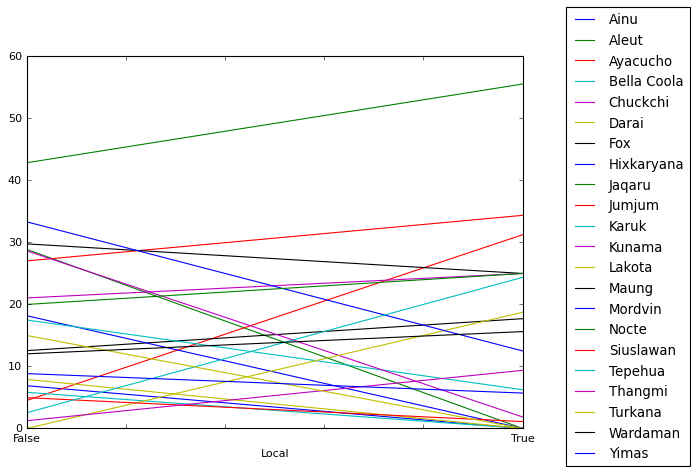

In [36]:
ax = cf['Cell ratio'].dropna().T.plot(figsize=(8, 6), legend=False)
ax.legend(bbox_to_anchor=(1.35, 1.15));

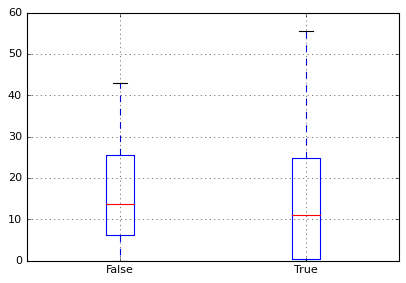

In [37]:
cf['Cell ratio'].boxplot(return_type='axes');

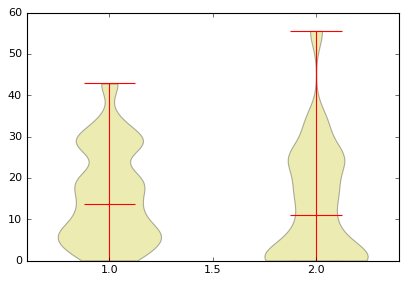

In [38]:
fig, ax = plt.subplots()

ax.violinplot(cf['Cell ratio'].dropna().values, showmedians=True, bw_method=.25);

In [39]:
cf[['Markers', 'Portmx', 'Ratio (norm)', 'Cell ratio (norm)']]

Markers      Portmx      Ratio (norm)           Cell ratio (norm)  \
Local         False True  False True        False      True             False   
Language                                                                        
Ainu             41   12      2    0     1.000000  0.000000          1.000000   
Aleut            66   33     21    0     1.000000  0.000000          1.000000   
Ayacucho         62   22      4    4     0.261905  0.738095          0.126214   
Bella Coola      37   21      3    0     1.000000  0.000000          1.000000   
Chuckchi         29   12      5    4     0.340909  0.659091          0.457143   
Darai            53   20      4    0     1.000000  0.000000          1.000000   
Fox             115   24     14    4     0.422111  0.577889          0.414802   
Hixkaryana       22    6      4    0     1.000000  0.000000          1.000000   
Jaqaru            9    7      3    4     0.368421  0.631579          0.435484   
Jumjum           55   19     12    5     0.453280  0.546720          0.440136   
Karuk            25   11      4    1     0.637681  0.362319          0.736842   
Ket             196   22      0    0          NaN       NaN               NaN   
Kunama          139   47     37    1     0.925985  0.074015          0.939297   
Lakota           42   20      0    2     0.000000  1.000000          0.000000   
Maricopa         16   16      0    0          NaN       NaN               NaN   
Maung           255   18     69    5     0.493445  0.506555          0.543582   
Mordvin          31    9     10    1     0.743802  0.256198          0.727273   
Nocte            22    8      4    2     0.421053  0.578947          0.444444   
Reyesano         32   12      0    0          NaN       NaN               NaN   
Sahu            195   24      0    0          NaN       NaN               NaN   
Siuslawan       178   61     12    1     0.804396  0.195604          0.817308   
Tepehua          56   32      2    9     0.112676  0.887324          0.094244   
Thangmi          39   18      1    3     0.133333  0.866667          0.117647   
Turkana          28   10      4    0     1.000000  0.000000          1.000000   
Wardaman         67   25      8    4     0.427350  0.572650          0.435146   
Yimas           153   76     15    7     0.515604  0.484396          0.607977   

                       
Local            True  
Language               
Ainu         0.000000  
Aleut        0.000000  
Ayacucho     0.873786  
Bella Coola  0.000000  
Chuckchi     0.542857  
Darai        0.000000  
Fox          0.585198  
Hixkaryana   0.000000  
Jaqaru       0.564516  
Jumjum       0.559864  
Karuk        0.263158  
Ket               NaN  
Kunama       0.060703  
Lakota       1.000000  
Maricopa          NaN  
Maung        0.456418  
Mordvin      0.272727  
Nocte        0.555556  
Reyesano          NaN  
Sahu              NaN  
Siuslawan    0.182692  
Tepehua      0.905756  
Thangmi      0.882353  
Turkana      0.000000  
Wardaman     0.564854  
Yimas        0.392023

In [40]:
pd.DataFrame([pearsonr(cfp, 'Local', f'{c} (norm)') for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Local & Perc (norm),-0.291594,0.054795
Local & Ratio (norm),-0.277682,0.068004
Local & Cell ratio (norm),-0.306743,0.042843


In [41]:
cfp[[f'{c} (norm)' for c in ['Perc', 'Ratio', 'Cell ratio']]].corr()

,Perc (norm),Ratio (norm),Cell ratio (norm)
Perc (norm),1.000000,0.993548,0.983565
Ratio (norm),0.993548,1.000000,0.988801
Cell ratio (norm),0.983565,0.988801,1.000000


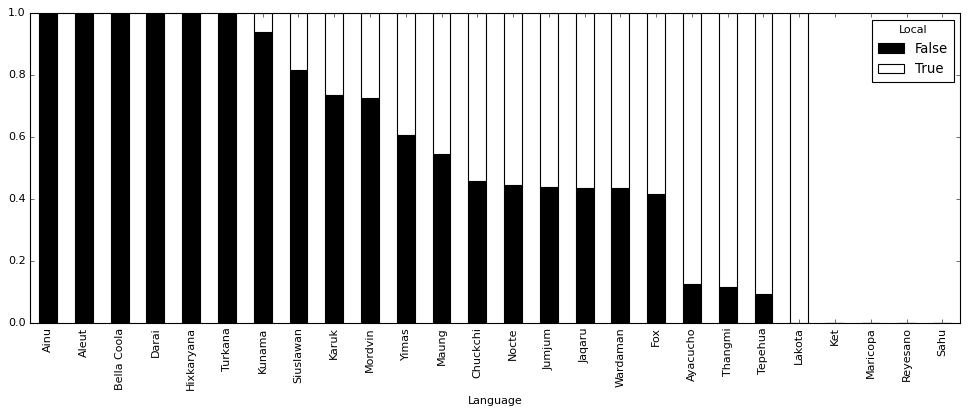

In [42]:
ax = (cf['Cell ratio (norm)'].sort_values(by=True, kind='mergesort')
      .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray))

#ax.get_figure().savefig('results_local_norm.pdf', bbox_inches='tight')

In [43]:
cf['Cell ratio (norm)'].sum().to_frame('Cell ratio (norm)').T

Local,False,True
Cell ratio (norm),13.337538,8.662462


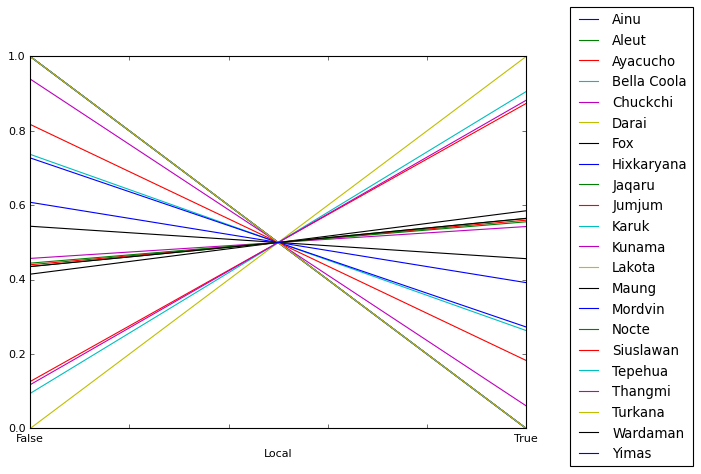

In [44]:
ax = cf['Cell ratio (norm)'].dropna().T.plot(figsize=(8, 6), legend=False)

ax.legend(bbox_to_anchor=(1.35, 1.15));

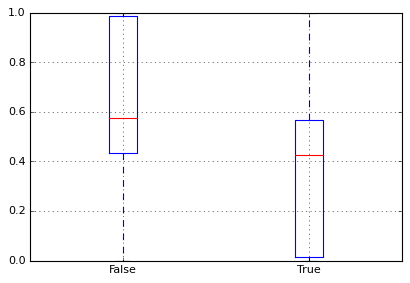

In [45]:
cf['Cell ratio (norm)'].boxplot(return_type='axes');

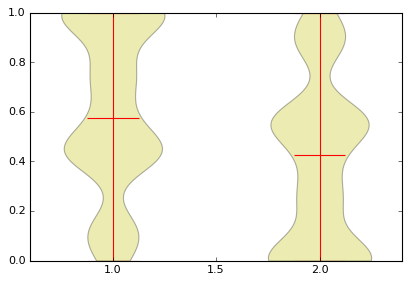

In [46]:
fig, ax = plt.subplots()

ax.violinplot(cf['Cell ratio (norm)'].dropna().values, showmedians=True, bw_method=.25);

# Direct

In [47]:
ctd = (df[df['Trans']]\
       .pivot_table('Position', ['Language', 'Direct'], 'Portmx', aggfunc=len, fill_value=0))

(ctd.join(ctd.groupby(level='Language').apply(fisher_exact))
 .rename_axis('Portmx', axis=1)
 .query('p <= .05'))

Portmx           False  True       odds         p
Language Direct                                  
Aleut    False      42     0        inf  0.000002
         True       36    21        inf  0.000002
Fox      False      53    14   0.222689  0.010231
         True       68     4   0.222689  0.010231
Jumjum   False      43     8   3.455357  0.037495
         True       14     9   3.455357  0.037495
Yimas    False      86     1  14.925620  0.000332
         True      121    21  14.925620  0.000332

In [48]:
cfd = (cells.reset_index()
       .groupby(['Language', 'Direct'])
       .agg({'Cell': 'size', 'Hasp': ntrue,
             'Markers': 'sum', 'Portmx': 'sum', 'Ratio': 'mean'})\
       .rename(columns={'Cell': 'Cells', 'Ratio': 'Cell ratio'}))

cfd.insert(2, 'Perc', 100 * cfd['Hasp'] / cfd['Cells'])
cfd.insert(5, 'Ratio', 100 * cfd['Portmx'] / cfd['Markers'])
nfd = cfd[['Perc', 'Ratio', 'Cell ratio']]
nfd /= nfd.groupby(level='Language').sum()
cfd = cfd.join(nfd, rsuffix=' (norm)')
cfd.loc[cfd['Perc (norm)'].isnull(), ['Perc', 'Ratio', 'Cell ratio']] = None

cfdp = cfd.reset_index('Direct')

cfd = cfd.unstack('Direct')

cfd.loc[:, :'Cell ratio']

Cells       Hasp            Perc            Markers      Portmx  \
Direct      False True False True      False       True   False True  False   
Language                                                                      
Ainu           18   19     0    2   0.000000  10.526316      29   24      0   
Aleut          27   36     0   16   0.000000  44.444444      42   57      0   
Ayacucho       14   18     4    4  28.571429  22.222222      47   37      4   
Bella Coola    12   16     2    1  16.666667   6.250000      29   29      2   
Chuckchi       11   16     1    8   9.090909  50.000000      18   23      1   
Darai          12   16     2    2  16.666667  12.500000      26   47      2   
Fox            18   22    14    4  77.777778  18.181818      67   72     14   
Hixkaryana     10   18     2    2  20.000000  11.111111      10   18      2   
Jaqaru          5    5     4    2  80.000000  40.000000       9    7      5   
Jumjum         16   20     7    8  43.750000  40.000000      51   23      8   
Karuk          12   16     2    3  16.666667  18.750000      18   18      2   
Ket            28   64     0    0        NaN        NaN      76  142      0   
Kunama         33   42     9   19  27.272727  45.238095      64  122     11   
Lakota         14   17     0    2   0.000000  11.764706      29   33      0   
Maricopa       12   12     0    0        NaN        NaN      20   12      0   
Maung          34   70    12   49  35.294118  70.000000      83  190     16   
Mordvin        12   16     3    7  25.000000  43.750000      14   26      4   
Nocte          12   16     2    4  16.666667  25.000000      12   18      2   
Reyesano       12   16     0    0        NaN        NaN      24   20      0   
Sahu           34   70     0    0        NaN        NaN      73  146      0   
Siuslawan      33   42     4    6  12.121212  14.285714     108  131      4   
Tepehua        14   17     3    5  21.428571  29.411765      46   42      6   
Thangmi        12   16     2    1  16.666667   6.250000      25   32      3   
Turkana        12   16     0    4   0.000000  25.000000      18   20      0   
Wardaman       16   19     2    9  12.500000  47.368421      47   45      3   
Yimas          27   36     1   15   3.703704  41.666667      87  142      1   

                      Ratio            Cell ratio             
Direct      True      False       True      False       True  
Language                                                      
Ainu           2   0.000000   8.333333   0.000000  10.526316  
Aleut         21   0.000000  36.842105   0.000000  36.111111  
Ayacucho       4   8.510638  10.810811   7.738095  13.888889  
Bella Coola    1   6.896552   3.448276   5.555556   3.125000  
Chuckchi       8   5.555556  34.782609   4.545455  34.375000  
Darai          2   7.692308   4.255319   8.333333   3.645833  
Fox            4  20.895522   5.555556  22.314815   6.439394  
Hixkaryana     2  20.000000  11.111111  20.000000  11.111111  
Jaqaru         2  55.555556  28.571429  63.333333  30.000000  
Jumjum         9  15.686275  39.130435  17.604167  37.500000  
Karuk          3  11.111111  16.666667   8.333333  18.750000  
Ket            0        NaN        NaN        NaN        NaN  
Kunama        27  17.187500  22.131148  18.181818  25.396825  
Lakota         2   0.000000   6.060606   0.000000   8.823529  
Maricopa       0        NaN        NaN        NaN        NaN  
Maung         58  19.277108  30.526316  18.627451  34.642857  
Mordvin        7  28.571429  26.923077  22.222222  31.250000  
Nocte          4  16.666667  22.222222  16.666667  25.000000  
Reyesano       0        NaN        NaN        NaN        NaN  
Sahu           0        NaN        NaN        NaN        NaN  
Siuslawan      9   3.703704   6.870229   2.979798   4.880952  
Tepehua        5  13.043478  11.904762   8.571429   7.843137  
Thangmi        1  12.000000   3.125000   6.250000   1.562500  
Turkana        4   0.000000  20.000000   0.000000  18.750000  
Wardaman       9   

In [49]:
pd.DataFrame([pearsonr(cfdp, 'Direct', c) for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Direct & Perc,0.178565,0.246163
Direct & Ratio,0.215627,0.159804
Direct & Cell ratio,0.242860,0.112182


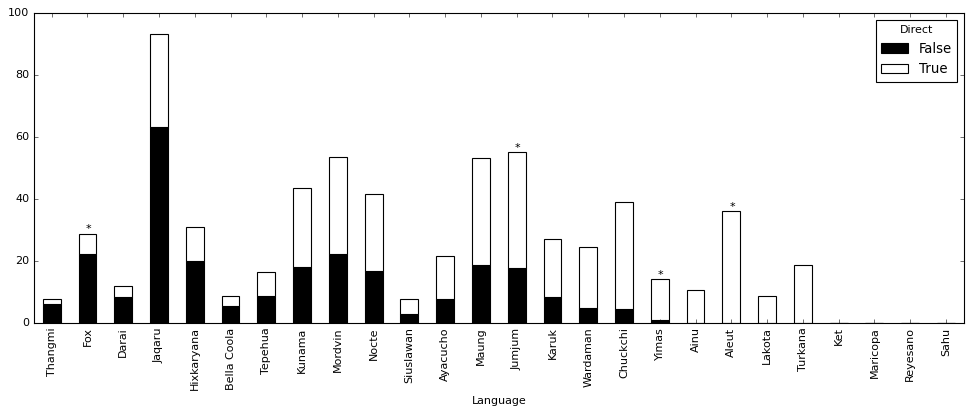

In [50]:
ax = (cfd.sort_values(by=('Cell ratio (norm)', True), kind='mergesort')['Cell ratio']
      .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray))

for x, lang in [(19, 'Aleut'), (1, 'Fox'), (13, 'Jumjum'), (17, 'Yimas')]:
    ax.annotate('*', (x - .05, cfd.loc[lang, 'Cell ratio'].sum() + .5))

#ax.get_figure().savefig('results_direct.pdf', bbox_inches='tight')

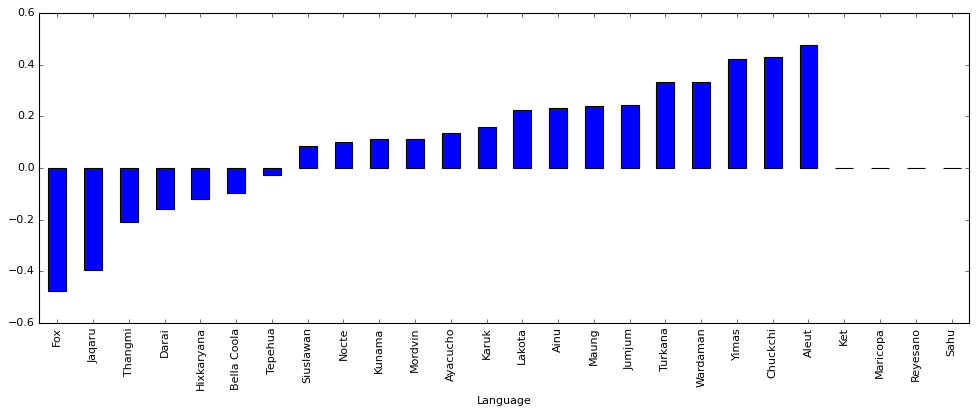

In [51]:
(cells.groupby(level='Language').apply(lambda x: pearsonr(x, 'Direct', 'Ratio'))['r']
 .sort_values(kind='mergesort')
 .plot.bar(figsize=(15, 5)));

In [52]:
cfd[['Markers', 'Portmx', 'Ratio (norm)', 'Cell ratio (norm)']]

Markers      Portmx      Ratio (norm)           Cell ratio (norm)  \
Direct        False True  False True        False      True             False   
Language                                                                        
Ainu             29   24      0    2     0.000000  1.000000          0.000000   
Aleut            42   57      0   21     0.000000  1.000000          0.000000   
Ayacucho         47   37      4    4     0.440476  0.559524          0.357798   
Bella Coola      29   29      2    1     0.666667  0.333333          0.640000   
Chuckchi         18   23      1    8     0.137725  0.862275          0.116788   
Darai            26   47      2    2     0.643836  0.356164          0.695652   
Fox              67   72     14    4     0.789969  0.210031          0.776054   
Hixkaryana       10   18      2    2     0.642857  0.357143          0.642857   
Jaqaru            9    7      5    2     0.660377  0.339623          0.678571   
Jumjum           51   23      8    9     0.286159  0.713841          0.319471   
Karuk            18   18      2    3     0.400000  0.600000          0.307692   
Ket              76  142      0    0          NaN       NaN               NaN   
Kunama           64  122     11   27     0.437134  0.562866          0.417219   
Lakota           29   33      0    2     0.000000  1.000000          0.000000   
Maricopa         20   12      0    0          NaN       NaN               NaN   
Maung            83  190     16   58     0.387064  0.612936          0.349678   
Mordvin          14   26      4    7     0.514851  0.485149          0.415584   
Nocte            12   18      2    4     0.428571  0.571429          0.400000   
Reyesano         24   20      0    0          NaN       NaN               NaN   
Sahu             73  146      0    0          NaN       NaN               NaN   
Siuslawan       108  131      4    9     0.350267  0.649733          0.379073   
Tepehua          46   42      6    5     0.522822  0.477178          0.522184   
Thangmi          25   32      3    1     0.793388  0.206612          0.800000   
Turkana          18   20      0    4     0.000000  1.000000          0.000000   
Wardaman         47   45      3    9     0.241935  0.758065          0.191919   
Yimas            87  142      1   21     0.072118  0.927882          0.065436   

                       
Direct           True  
Language               
Ainu         1.000000  
Aleut        1.000000  
Ayacucho     0.642202  
Bella Coola  0.360000  
Chuckchi     0.883212  
Darai        0.304348  
Fox          0.223946  
Hixkaryana   0.357143  
Jaqaru       0.321429  
Jumjum       0.680529  
Karuk        0.692308  
Ket               NaN  
Kunama       0.582781  
Lakota       1.000000  
Maricopa          NaN  
Maung        0.650322  
Mordvin      0.584416  
Nocte        0.600000  
Reyesano          NaN  
Sahu              NaN  
Siuslawan    0.620927  
Tepehua      0.477816  
Thangmi      0.200000  
Turkana      1.000000  
Wardaman     0.808081  
Yimas        0.934564

In [53]:
pd.DataFrame([pearsonr(cfdp, 'Direct', f'{c} (norm)') for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Direct & Perc (norm),0.406578,0.006168
Direct & Ratio (norm),0.416424,0.004928
Direct & Cell ratio (norm),0.457289,0.001804


In [54]:
cfdp[[f'{c} (norm)' for c in ['Perc', 'Ratio', 'Cell ratio']]].corr()

,Perc (norm),Ratio (norm),Cell ratio (norm)
Perc (norm),1.000000,0.958776,0.955347
Ratio (norm),0.958776,1.000000,0.990275
Cell ratio (norm),0.955347,0.990275,1.000000


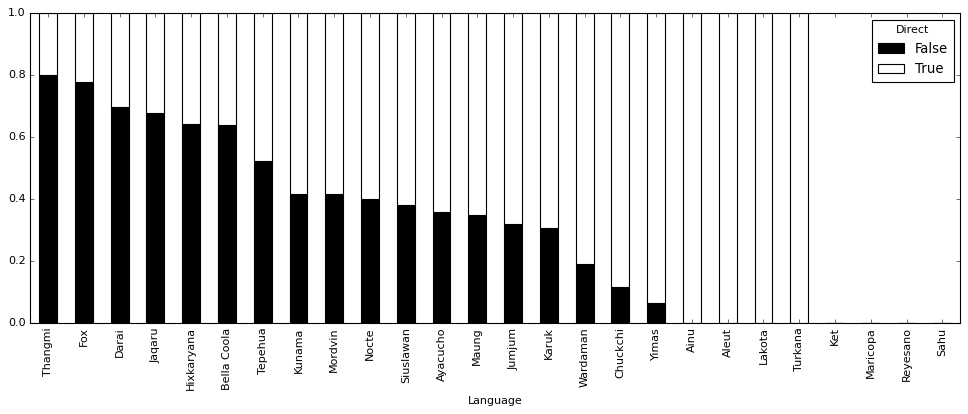

In [55]:
ax = (cfd['Cell ratio (norm)'].sort_values(by=True, kind='mergesort')
      .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray))

#ax.get_figure().savefig('results_direct_norm.pdf', bbox_inches='tight')

In [56]:
cfd['Cell ratio (norm)'].sum().to_frame('Cell ratio (norm)').T

Direct,False,True
Cell ratio (norm),8.075977,13.924023
